In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os

RANDOM_SEED = 42

In [2]:
!pip install --upgrade pip

  Using cached pip-23.3.2-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.2-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\zoric\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical # needed to one-hot encode labels
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install keras-tuner
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\zoric\AppData\Local\Temp\ipykernel_3728\3986942730.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Specify each path

In [5]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [6]:
NUM_CLASSES = 8

# Dataset reading

In [35]:
X_train = np.loadtxt('model/keypoint_classifier/keypointsTrain.csv', delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 4))) #+4
y_train = np.loadtxt('model/keypoint_classifier/keypointsTrain.csv', delimiter=',', dtype='int32', usecols=(0))
X_val = np.loadtxt('model/keypoint_classifier/keypointsVal.csv', delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 4)))
y_val = np.loadtxt('model/keypoint_classifier/keypointsVal.csv', delimiter=',', dtype='int32', usecols=(0))
X_test = np.loadtxt('model/keypoint_classifier/keypointsTest.csv', delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 4)))
y_test = np.loadtxt('model/keypoint_classifier/keypointsTest.csv', delimiter=',', dtype='int32', usecols=(0))

[1719, 146, 137] 2002


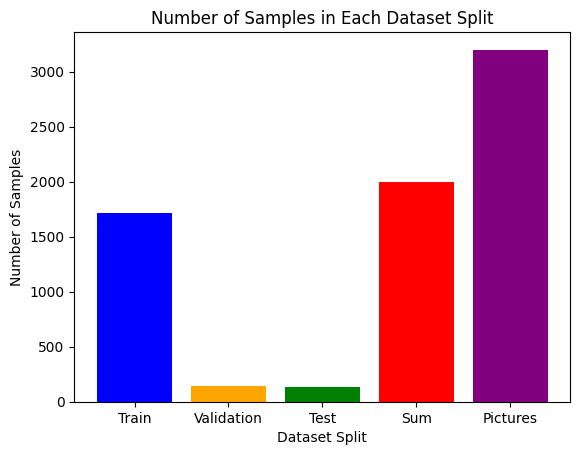

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
file_paths = [
    'model/keypoint_classifier/keypointsTrain.csv',
    'model/keypoint_classifier/keypointsVal.csv',
    'model/keypoint_classifier/keypointsTest.csv'
]

num_lines = []

# Count lines in each file
for file_path in file_paths:
    with open(file_path, 'r') as file:
        num_lines.append(sum(1 for line in file))

# Calculate total number of lines
total_lines = sum(num_lines)
print(num_lines, total_lines)
# Add total lines to the list
num_lines.append(total_lines)
num_lines.append(3200)
labels = ['Train', 'Validation', 'Test', 'Sum', 'Pictures']

# Plot the number of lines
plt.bar(labels, num_lines, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Dataset Split')
plt.show()


In [7]:
#X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

# Old Model building and training without Paramtertuning

In [1]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2 + 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

NameError: name 'tf' is not defined

In [29]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [30]:
#Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/14 [=>............................] - ETA: 5s - loss: 2.1546 - accuracy: 0.1250
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 1s 14ms/step - loss: 2.1948 - accuracy: 0.1373 - val_loss: 2.0822 - val_accuracy: 0.1096
Epoch 2/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.1752 - accuracy: 0.1562
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 0s 7ms/step - loss: 2.0987 - accuracy: 0.1495 - val_loss: 2.0614 - val_accuracy: 0.1301
Epoch 3/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.0865 - accuracy: 0.1641
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 0s 7ms/step - loss: 2.0855 - accuracy: 0.1594 - val_loss: 2.0478 - val_accuracy: 0.1712
Epoch 4/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.1007 - accuracy: 0.1562


In [32]:
# Model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 3ms/step - loss: 1.0292 - accuracy: 0.6277


# Optimized Model building and Paramtertuning

In [36]:
def create_dir(path):
    os.makedirs(path, exist_ok=True)
create_dir("files")
model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "data.csv")

In [37]:
def build_model(hp):  
    model = keras.Sequential()

    # # input layer
    model.add(layers.InputLayer(21 * 2 + 3)) # make 1 dimensional array out of 21x2 array

    # # only for simple one
    # # model.add(
    # #     layers.Dense( 
    # #         units=1024,
    # #         activation="relu"
    # #     )
    # # )
    
    # # model.add(
    # #     layers.Dense( # dense = every input neuron is connected to every next neuron
    # #         units=hp.Int("units", min_value=128, max_value=1024, step=128), # tune the number of neurons
    # #         #units=1024,
    # #         #activation=hp.Choice("activation", ["relu", "tanh"]), # tune the activation function; relu should be best
    # #         activation="relu"
    # #     )
    # # )

    
    #ACTUAL ONE 
    for i in range(hp.Int('num_layers', 2, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=64,
                                            max_value=512,
                                            step=32),
                               activation='relu'))

    
    # tune whether to use dropout
    if hp.Boolean("dropout"):
      model.add(layers.Dropout(rate=0.2))
    #TODO

    # output layer
    model.add(layers.Dense(8, activation="softmax")) # probability of every output neuron which all add up to 1

    # tune learning rate 
    #learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    learning_rate = 1e-3 # 1e-3 = 0.001
    
    model.compile(loss="sparse_categorical_crossentropy",
                  #optimizer="adam",
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"]
    )
    
    return model



""" Model """
tuner = RandomSearch(
    hypermodel=build_model,
    objective = 'val_accuracy', 
    max_trials = 30, # total number of trials to run during search; should be as high as all combinations possible; default is 10
    executions_per_trial = 2, # number of models that should be built and fit for each trial; executions within trial have same hyperparameter values
    directory='output', # where to store search results
    overwrite = True # overwrite previous results in same directory
)

""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    # if within 50 epochs the val_loss does not decrease, the model will stop training
    EarlyStopping(monitor='val_accuracy', mode='max', patience=25)
]


# search best hyperparameter configuration; all arguments passed to search() are also passed to model.fit() in each execution
tuner.search(
    x = X_train,
    y = y_train,
    epochs = 400,
    batch_size = 32,
    validation_data = (X_val, y_val),
    callbacks=callbacks
)

best_model = tuner.get_best_models()[0]  # Get the best model found by the tuner
best_model.build(layers.InputLayer(21*2+3))
best_model.summary()
tuner.results_summary()

    
# RETRAIN MODEL WITH WHOLE DATASET AND BEST HYPERPARAMETERS
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("----------------------------------------------------")
print("best values:")
print(best_hps.values)
print("----------------------------------------------------")
model = build_model(best_hps)

history = model.fit(
    x = X_train,
    y = y_train,
    epochs = 400,
    batch_size = 32,
    validation_data = (X_val, y_val),
    callbacks=callbacks
)




Trial 30 Complete [00h 00m 28s]
val_accuracy: 0.9554794430732727

Best val_accuracy So Far: 0.9623287618160248
Total elapsed time: 00h 16m 08s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                4416      
                                                                 
 dense_1 (Dense)             (None, 416)               40352     
                                                                 
 dense_2 (Dense)             (None, 256)               106752    
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 153,576
Trainable params: 153,576
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in output\untit

In [38]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                4416      
                                                                 
 dense_1 (Dense)             (None, 416)               40352     
                                                                 
 dense_2 (Dense)             (None, 256)               106752    
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 153,576
Trainable params: 153,576
Non-trainable params: 0
_________________________________________________________________


In [39]:
# TEST
evaluation = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.3791 - accuracy: 0.9416


In [13]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 160)               7360      
                                                                 
 dense_5 (Dense)             (None, 128)               20608     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
Total params: 36,744
Trainable params: 36,744
Non-trainable params: 0
_________________________________________________________________


# Load Saved Model

In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[6.3975823e-17 4.5440653e-13 2.7222922e-16 1.3282307e-12 1.5612686e-06
 9.9999845e-01 5.9579486e-10 1.2638474e-10]
5


# Confusion matrix

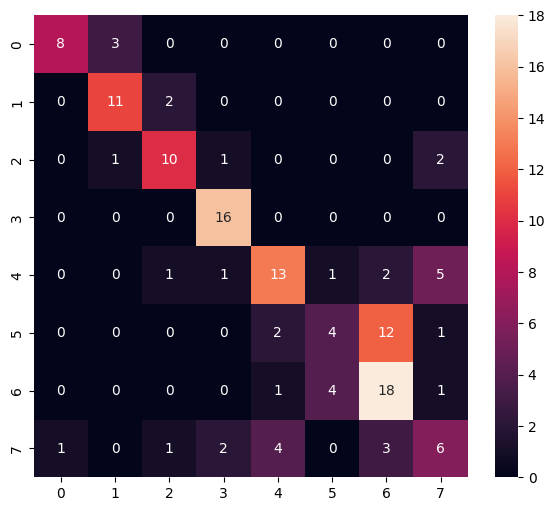

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.85      0.79        13
           2       0.71      0.71      0.71        14
           3       0.80      1.00      0.89        16
           4       0.65      0.57      0.60        23
           5       0.44      0.21      0.29        19
           6       0.51      0.75      0.61        24
           7       0.40      0.35      0.38        17

    accuracy                           0.63       137
   macro avg       0.64      0.65      0.63       137
weighted avg       0.62      0.63      0.61       137



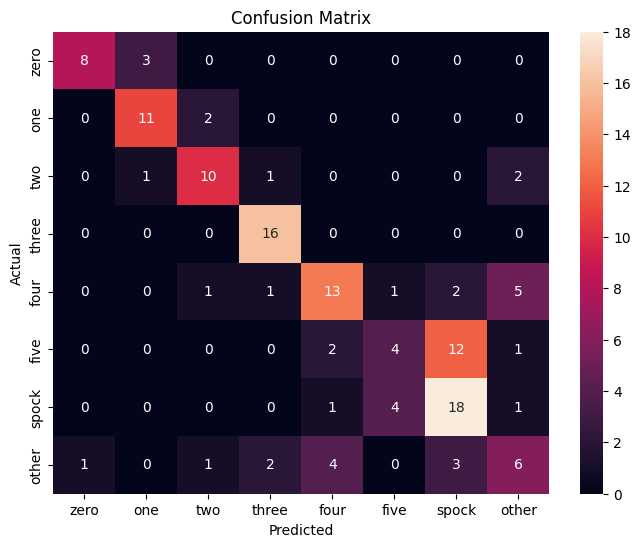

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
   

print_confusion_matrix(y_test, y_pred)
class_names = ["zero", "one", "two", "three", "four", "five", "spock","other"]
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

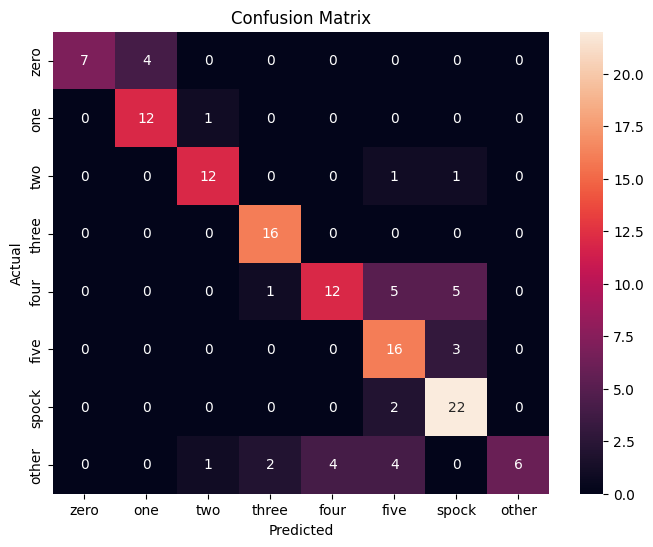

   ACTUAL LABEL PREDICTED LABEL  FILE NAME OF IMAGE
0          five           spock                   5
1          four           spock                   4
2          four           three                   4
3         other           three                   7
4         other            five                   7
5         other            five                   7
6         other            four                   7
7         other            four                   6
8         spock            five                   6
9          zero             one                   0
10         four            five                   4
11         four           spock                   4
12         four            five                   1
13        other           three                   7
14        other            four                   7
15        other            four                   7
16        other            five                   7
17        other            five                   7
18        ot

In [22]:
# Get predictions from the model
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
class_names = ["zero", "one", "two", "three", "four", "five", "spock","other"]
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




# SHOW WHICH ONES HAVE BEEN PREDICTED INCORRECTLY

incorrect_indices = np.where(y_test != y_pred)[0] 
# Read the first row of the test dataset CSV file to get file names
test_file_names = pd.read_csv("model/keypoint_classifier/keypointsTest.csv", usecols=[0]).values.flatten()

# one dimensional array which contains file names of incorrect files
incorrect_files = np.array(test_file_names)[incorrect_indices] 

# Create a DataFrame for incorrectly predicted images
data = {
    'ACTUAL LABEL': [class_names[y_test[i]] for i in incorrect_indices],
    'PREDICTED LABEL': [class_names[y_pred[i]] for i in incorrect_indices],
    'FILE NAME OF IMAGE': incorrect_files
}

incorrect_df = pd.DataFrame(data)

print(incorrect_df)

# Convert to model for Tensorflow-Lite

In [60]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [55]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zoric\AppData\Local\Temp\tmpxn5e4kfe\assets


81072

# Inference test

In [56]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [57]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [58]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [60]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.51 ms


In [61]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.1258652e-17 4.5580233e-13 2.8868206e-16 1.3931134e-12 1.5985793e-06
 9.9999845e-01 5.2524779e-10 1.4733154e-10]
5
